### **Nama: Muhammad Amanda**
### **Username: muh_amanda** 
### **Kota: Kota Jakarta Timur, DKI Jakarta**
### *Waktu bergabung pada 12 May 2020*

# Proyek Akhir : Image Classification Model Deployment

In [8]:
# Import library yang dibutuhkan
import zipfile,os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip



--2021-06-28 23:29:38--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  5.84MB/s    in 63s     

2021-06-28 23:30:42 (4.85 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors'
paper_dir = os.path.join(base_dir, 'paper')
rock_dir = os.path.join(base_dir, 'rock')
scissors_dir = os.path.join(base_dir, 'scissors')



In [5]:
dir_path = '/tmp/rockpaperscissors/rps-cv-images'
try: 
  shutil.rmtree(dir_path)
except OSError as e:
  print("Error: %s: %s" % (dir_path, e.strerror))

file_path = '/tmp/rockpaperscissors/README_rpc-cv-images.txt'
try: 
  os.remove(file_path)
except OSError as e:
  print("Error: %s: %s" % (dir_path, e.strerror))

  file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)


df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

df.head()

Error: /tmp/rockpaperscissors/rps-cv-images: No such file or directory
Error: /tmp/rockpaperscissors/rps-cv-images: No such file or directory


,path,file_name,tag
0,/tmp/rockpaperscissors/scissors/XWF7hCQnD6qfJU...,XWF7hCQnD6qfJUCI.png,scissors
1,/tmp/rockpaperscissors/scissors/dkrdiLQ61q78gi...,dkrdiLQ61q78gidZ.png,scissors
2,/tmp/rockpaperscissors/scissors/AIdBo3sdoduT52...,AIdBo3sdoduT52KJ.png,scissors
3,/tmp/rockpaperscissors/scissors/HGhHQ3uNh7XFl2...,HGhHQ3uNh7XFl2ar.png,scissors
4,/tmp/rockpaperscissors/scissors/L6O2HLgQIo7Xdf...,L6O2HLgQIo7XdfdU.png,scissors


## Membagi Dataset menjadi Data Train dan Data Validation
Data Train sebesar 80% dan Data Validation sebesar 20%

In [9]:
X= df['path']
y= df['tag']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42)

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})
df_all = df_tr.append(df_val).reset_index(drop=1)

datasource_path = '/tmp/rockpaperscissors'
dataset_path = "/tmp/dataset"
for index, row in tq(df_all.iterrows()):

    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            

    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150), 
        batch_size=32,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size=(150, 150), 
        batch_size=32, 
        class_mode='categorical',
        shuffle=True)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])


Found 1750 images belonging to 3 classes.
Found 438 images belonging to 3 classes.


# Latih Model
Selain melatih model, juga mengukur waktu pelatihan model dan menyimpan epoch terbaik berdasarkan `val_accuracy` terbesar. Dalam hal ini, model telah cukup baik dengan memperoleh akurasi dari data validation dengan sangat besar.

In [10]:
import time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(datasource_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
start_time = time.time()
history = model.fit(
      train_generator,
      steps_per_epoch=25, 
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=5, 
      verbose=2,
      callbacks=callbacks_list)
print("waktu latih: %s detik" % (time.time() - start_time))

Epoch 1/20
25/25 - 41s - loss: 2.1340 - accuracy: 0.3625 - val_loss: 0.9907 - val_accuracy: 0.4625

Epoch 00001: val_accuracy improved from -inf to 0.46250, saving model to /tmp/rockpaperscissors
INFO:tensorflow:Assets written to: /tmp/rockpaperscissors/assets
Epoch 2/20
25/25 - 39s - loss: 0.8358 - accuracy: 0.6418 - val_loss: 0.8509 - val_accuracy: 0.6687

Epoch 00002: val_accuracy improved from 0.46250 to 0.66875, saving model to /tmp/rockpaperscissors
INFO:tensorflow:Assets written to: /tmp/rockpaperscissors/assets
Epoch 3/20
25/25 - 39s - loss: 0.5371 - accuracy: 0.7862 - val_loss: 0.4669 - val_accuracy: 0.8500

Epoch 00003: val_accuracy improved from 0.66875 to 0.85000, saving model to /tmp/rockpaperscissors
INFO:tensorflow:Assets written to: /tmp/rockpaperscissors/assets
Epoch 4/20
25/25 - 39s - loss: 0.4055 - accuracy: 0.8600 - val_loss: 0.4482 - val_accuracy: 0.8188

Epoch 00004: val_accuracy did not improve from 0.85000
Epoch 5/20
25/25 - 39s - loss: 0.3905 - accuracy: 0.8468

# Plot Training Loss vs Validation loss
Dari plot di bawah terlihat bahwa berdasarkan training loss dengan validation loss mengindikasikan model *good fit* dengan tidak *overfitting* maupun *underfitting*. 

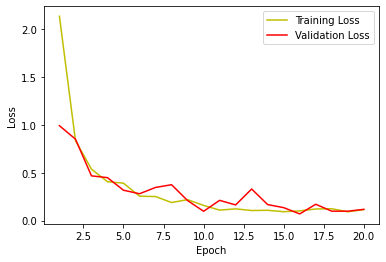

In [11]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'y', label="Training Loss")
plt.plot(epoch_count, validation_loss, 'r', label="Validation Loss")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot Training Accuracy vs Validation Accuracy
Dari plot di bawah terlihat bahwa berdasarkan training accuracy dengan validation accuracy mengindikasikan model *good fit* dengan tidak *overfitting* maupun *underfitting*. 

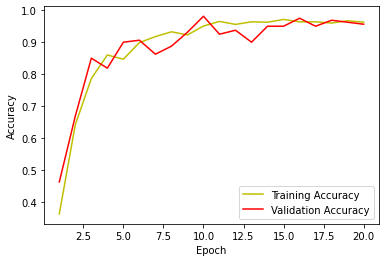

In [12]:
train_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'y', label="Training Accuracy")
plt.plot(epoch_count, validation_loss, 'r', label="Validation Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Membuat Model dalam Format tflite


In [13]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpo9yagh9k/assets
